In [252]:
%matplotlib inline
import numpy as np
import math
import pandas as pd
import pickle
import sys
from collections import Counter
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib.pyplot as plt

In [253]:
import seaborn as sns

sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

In [254]:
fname = 'data/prediction_data.csv'
data = pd.read_csv(fname)
data.shape

(11751, 53)

In [255]:
fname = 'data/prediction_data.csv'
data = pd.read_csv(fname)
fname = 'data/data.csv'
rawdata = pd.read_csv(fname)
rawdata = rawdata.iloc[:, 10:66]
data = pd.concat([data, rawdata], axis=1)
data = data[data['Season']<1819]

In [256]:
result = Counter(data['Result'])
print('Home Win : {} ({:.3f}%)'.format(result['H'], (result['H']/len(data['Result'])*100)))
print('Draw : {} ({:.3f}%)'.format(result['D'], (result['D']/len(data['Result'])*100)))
print('Away Win : {} ({:.3f}%)'.format(result['A'], (result['A']/len(data['Result'])*100)))


Home Win : 5353 (46.318%)
Draw : 2841 (24.583%)
Away Win : 3363 (29.099%)


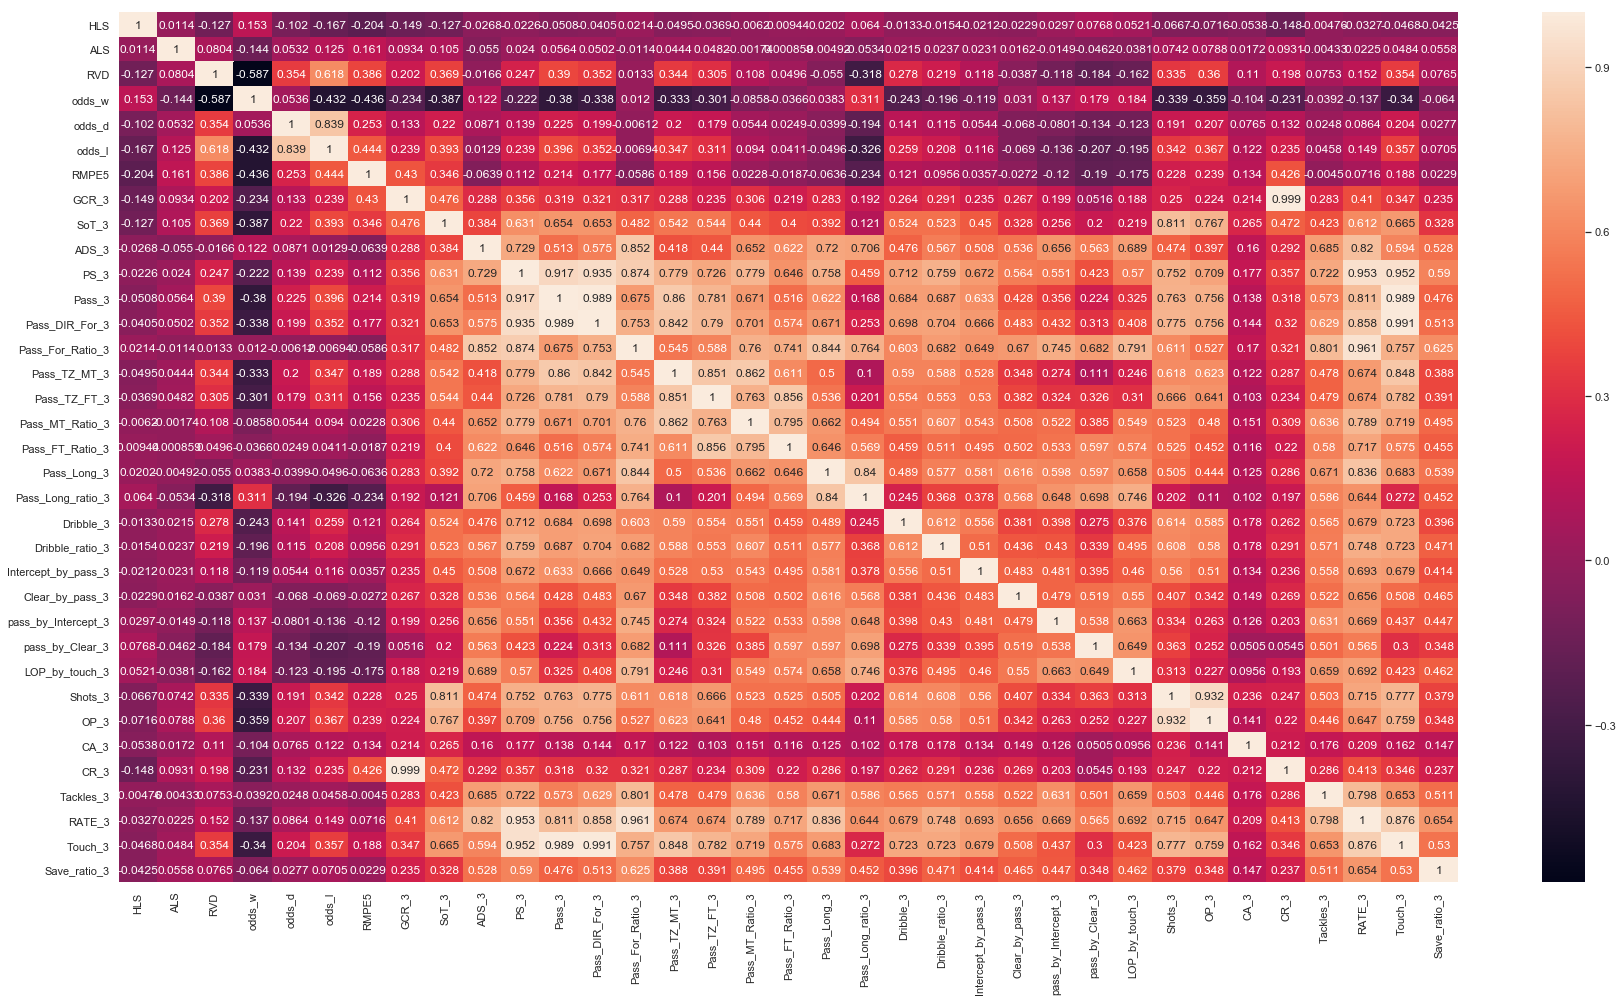

In [257]:
corr = data.iloc[:,18:53].corr()
f, ax = plt.subplots(figsize=(30, 16))
#ax.set_title('Standard deviation of seasonal win odds')
ax = sns.heatmap(corr, annot=True, fmt='.3g')

In [258]:
LALIGA = data[data['League'] == 'LALIGA'].reset_index(drop=True)
EPL = data[data['League'] == 'EPL'].reset_index(drop=True)
SERIE = data[data['League'] == 'SERIE'].reset_index(drop=True)
BUNDES = data[data['League'] == 'BUNDES'].reset_index(drop=True)

In [259]:
LALIGA_teams = LALIGA['Home_Name'].unique()
EPL_teams = EPL['Home_Name'].unique()
SERIE_teams = SERIE['Home_Name'].unique()
BUNDES_teams = BUNDES['Home_Name'].unique()

In [260]:
def calculateratio(row, f1, f2):
    ratio = row[f1]/row[f2]
    return ratio
def calculatesum(row, *args):
    sum_ = 0
    for i in args:sum_ += row[i]
    return sum_
def calculatediffer(row, *args):
    for idx, i in enumerate(args):
        if idx == 0:
            differ = row[i]
        else:
            differ -= row[i]
    return differ

In [261]:
leagues = data['League'].unique()
seasons = data['Season'].unique()
teams = data['Home_Name'].unique()

In [309]:
#시즌/리그/라운드 별 승점 계산
pts = {}
for league in leagues:
    for season in seasons:
        temp = data[(data['League']==league) & (data['Season']==season)].reset_index()
        leagueteams = temp['Home_Name'].unique()
        
        for team in leagueteams:
            team_pts = 0
            tempH = temp[temp['Home_Name']==team]
            count_w = Counter(tempH['Result'])['H']
            count_d = Counter(tempH['Result'])['D']
            team_pts += (count_w*3 + count_d)
            tempA = temp[temp['Away_Name']==team]
            count_l = Counter(tempA['Result'])['A']
            count_d = Counter(tempA['Result'])['D']
            team_pts += (count_l*3 + count_d)
            season_team = league+'_'+str(season)+'_'+team
            pts[season_team] = team_pts

dfL, dfS, dfT, dfP =[],[],[],[]
leagueTable = pd.DataFrame()
for league in leagues:
    for season in seasons:
        for team in teams:
            season_team = league+'_'+str(season)+'_'+team
            if season_team in pts:
                dfL.append(league)
                dfS.append(season)
                dfT.append(team)
                if league == 'BUNDES':
                    dfP.append(int(pts[season_team]*38/34))
                else:
                    dfP.append(pts[season_team])
leagueTable['League'] = dfL
leagueTable['Season'] = dfS
leagueTable['Team'] = dfT
leagueTable['Pts'] = dfP

In [312]:
ptsgroupby = leagueTable.groupby([leagueTable['League'], leagueTable['Season']]).std()
ptsgroupby = ptsgroupby.reset_index()

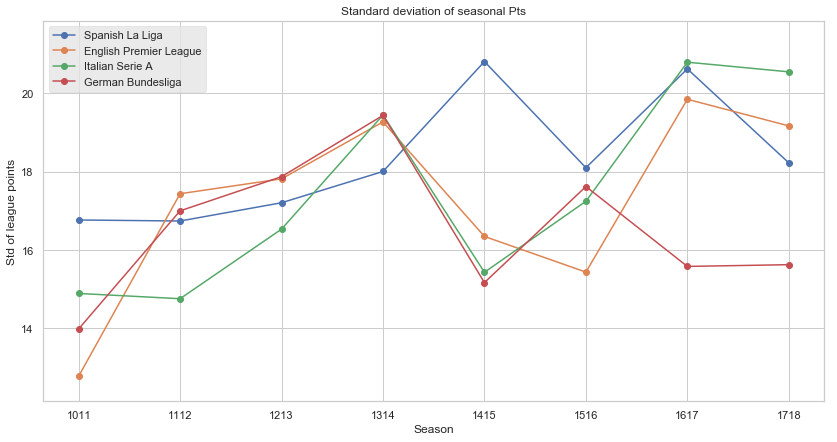

In [313]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)

plt.ylim(min(ptsgroupby['Pts']) - min(ptsgroupby['Pts']) * 0.05, max(ptsgroupby['Pts']) + max(ptsgroupby['Pts']) * 0.05)
ax.plot()
ax.set_title('Standard deviation of seasonal Pts')

plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel('Season')
plt.ylabel('Std of league points')
num_seasons = range(len(seasons))

plt.plot(num_seasons, ptsgroupby['Pts'][ptsgroupby['League']=='LALIGA'], label = "Spanish La Liga", marker = 'o')
plt.plot(num_seasons, ptsgroupby['Pts'][ptsgroupby['League']=='EPL'], label = "English Premier League", marker = 'o')
plt.plot(num_seasons, ptsgroupby['Pts'][ptsgroupby['League']=='SERIE'], label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons, ptsgroupby['Pts'][ptsgroupby['League']=='BUNDES'], label = "German Bundesliga", marker = 'o')

plt.legend(loc = 0)

In [314]:
#leagueTable[(leagueTable['League']=='LALIGA')&(leagueTable['Season']==1415)].sort_values('Pts', ascending=False).reset_index(drop=True)

In [315]:
#groupby = data[['Home_GF', 'Away_GF', 'odds_w', 'odds_d', 'odds_l']].groupby([data['League'], data['Season']]).describe()
groupby = data.groupby([data['League'], data['Season']]).std()
groupby = groupby.reset_index()
groupby['sum_std'] = groupby.apply(lambda row: calculatesum(row, 'odds_w', 'odds_d', 'odds_l'), axis=1)

In [316]:
groupby['Pts'] = ptsgroupby['Pts']

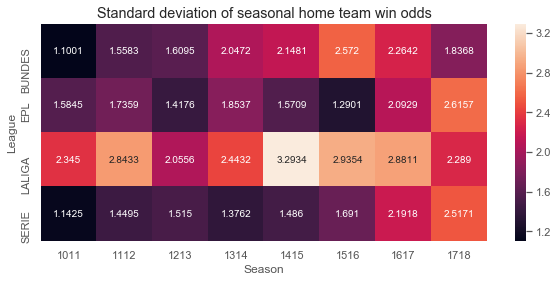

In [317]:
heatmap = groupby.pivot('League', 'Season', 'odds_w')
f, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Standard deviation of seasonal home team win odds')
ax = sns.heatmap(heatmap, annot=True, fmt='.5g')

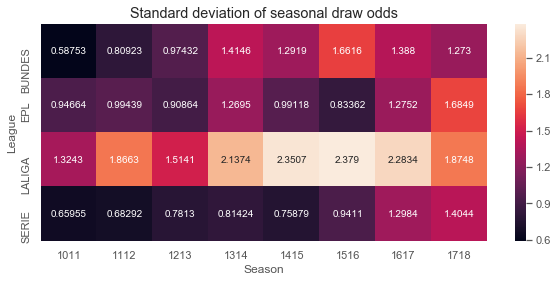

In [318]:
heatmap = groupby.pivot('League', 'Season', 'odds_d')
f, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Standard deviation of seasonal draw odds')
ax = sns.heatmap(heatmap, annot=True, fmt='.5g')

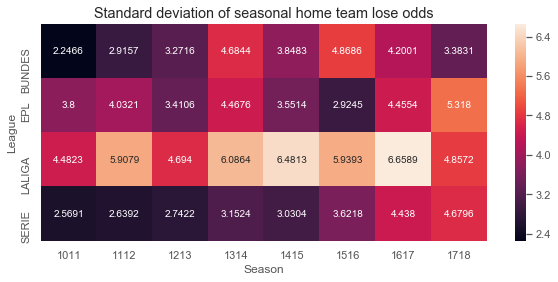

In [319]:
heatmap = groupby.pivot('League', 'Season', 'odds_l')
f, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Standard deviation of seasonal home team lose odds')
ax = sns.heatmap(heatmap, annot=True, fmt='.5g')

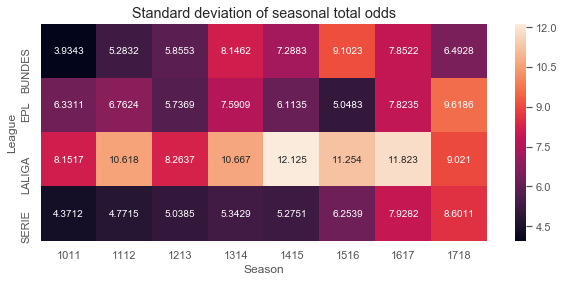

In [320]:
heatmap = groupby.pivot('League', 'Season', 'sum_std')
f, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Standard deviation of seasonal total odds')
ax = sns.heatmap(heatmap, annot=True, fmt='.5g')

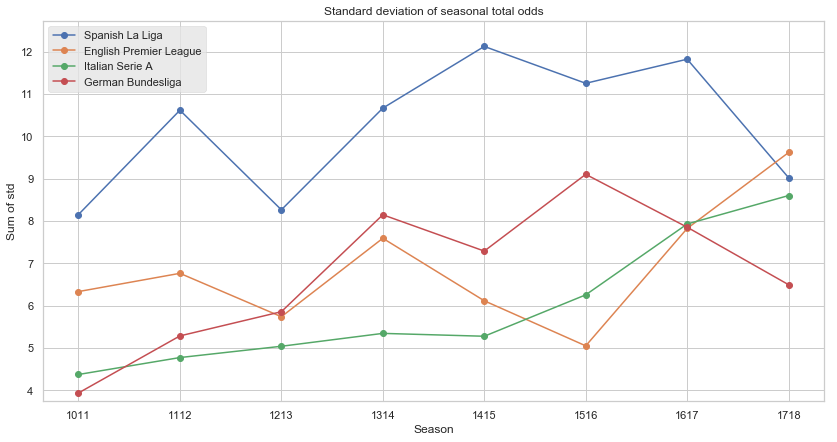

In [321]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)

plt.ylim(min(groupby['sum_std']) - min(groupby['sum_std']) * 0.05, max(groupby['sum_std']) + max(groupby['sum_std']) * 0.05)
ax.plot()
ax.set_title('Standard deviation of seasonal total odds')

plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel('Season')
plt.ylabel('Sum of std')
num_seasons = range(len(seasons))

plt.plot(num_seasons, groupby['sum_std'][groupby['League']=='LALIGA'], label = "Spanish La Liga", marker = 'o')
plt.plot(num_seasons, groupby['sum_std'][groupby['League']=='EPL'], label = "English Premier League", marker = 'o')
plt.plot(num_seasons, groupby['sum_std'][groupby['League']=='SERIE'], label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons, groupby['sum_std'][groupby['League']=='BUNDES'], label = "German Bundesliga", marker = 'o')

plt.legend(loc = 0)

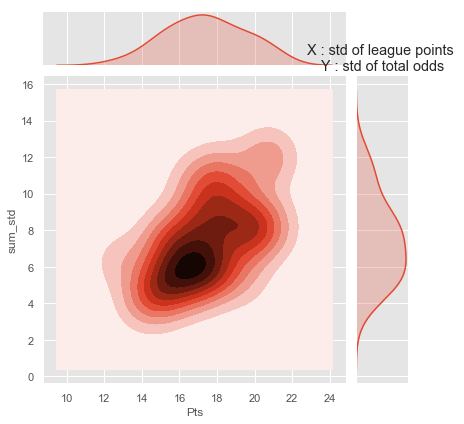

In [322]:
sns.jointplot(x='Pts', y='sum_std', data=groupby, kind='kde')
plt.title("X : std of league points \nY : std of total odds")
plt.show()

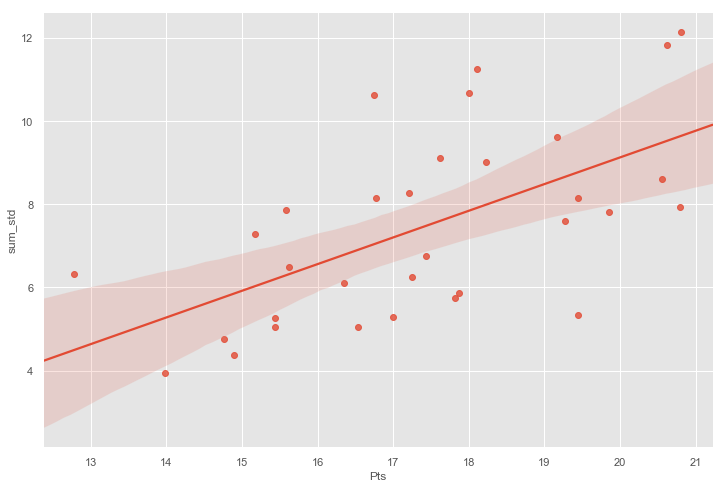

In [323]:
plt.figure(figsize=(12,8))
sns.regplot(x='Pts', y='sum_std', data=groupby)
plt.show()

In [330]:
groupby

,League,Season,MatchID,Match_Date,Home_GF,Away_GF,Home_IAR,Away_IAR,Home_IN,Away_IN,...,Home_Tackles,Away_Tackles,Home_RATE,Away_RATE,Home_Touch,Away_Touch,Home_Save_ratio,Away_Save_ratio,sum_std,Pts
0,BUNDES,1011,173.798891,4649.629553,1.337826,1.210529,2.393367,2.731931,1.854599,1.902186,...,6.412938,6.384015,0.404790,0.407631,88.102952,85.003657,0.116052,0.112990,3.934271,13.987389
1,BUNDES,1112,192.192131,4663.027969,1.367843,1.196771,1.493087,1.780781,1.845265,1.876187,...,6.470172,6.310700,0.423034,0.397141,101.605221,99.702118,0.125047,0.116461,5.283250,17.002499
2,BUNDES,1213,88.574458,4653.043066,1.340342,1.221355,1.627281,1.738769,1.818606,1.960217,...,6.012138,6.628554,0.412682,0.392019,105.537828,99.198623,0.122928,0.124178,5.855346,17.874746
3,BUNDES,1314,93.138745,4665.110366,1.383301,1.257264,1.255540,1.257356,1.916638,1.852706,...,6.138783,5.555376,0.425555,0.431087,116.261481,120.145837,0.346037,0.293692,8.146171,19.439617
4,BUNDES,1415,90.859921,4662.138921,1.320851,1.189889,1.589954,1.927092,1.937514,2.035570,...,5.708619,6.097314,0.362978,0.364766,128.713277,125.193109,0.114952,0.129212,7.288316,15.170491
5,BUNDES,1516,148.306451,4663.374959,1.363689,1.130151,1.278461,1.474921,1.818250,2.033144,...,5.669256,5.126148,0.368642,0.363440,145.896461,136.253346,0.124037,0.127900,9.102258,17.623143
6,BUNDES,1617,92.488896,4645.605962,1.321909,1.231572,0.881461,1.268125,1.851673,1.993090,...,5.469905,5.931008,0.361560,0.363466,136.443606,130.454333,0.119749,0.118784,7.852235,15.583740
7,BUNDES,1718,88.478811,4646.544662,1.282108,1.136033,1.029310,1.373041,2.010377,2.033619,...,5.556382,5.469967,0.342805,0.334295,118.193483,112.911962,0.301298,0.270179,6.492830,15.628029
8,EPL,1011,129.563287,4641.687850,1.240464,1.114236,1.456302,1.531821,1.829101,1.902459,...,6.134886,6.116044,0.342978,0.352836,93.525229,92.512621,0.268445,0.260589,6.331055,12.779404
9,EPL,1112,588.092927,4637.014694,1.331531,1.204987,1.285566,1.404520,2.158738,2.216041,...,5.563941,5.348550,0.367342,0.375385,115.734127,107.819528,0.279680,0.244529,6.762360,17.439444


In [324]:
groupby[['Pts','sum_std']].corr()

,Pts,sum_std
Pts,1.000000,0.597289
sum_std,0.597289,1.000000


In [25]:
#groupby[['League', 'Season', 'odds_w', 'odds_d', 'odds_l', 'sum_std', 'entropy']]

In [280]:
groupby = data[['Home_GF','Away_GF']].groupby([data['League'], data['Season']]).mean()
groupby = groupby.reset_index()
groupby['sum'] = groupby.apply(lambda row: calculatesum(row, 'Home_GF', 'Away_GF'), axis=1)
groupby['ratio'] = groupby.apply(lambda row: calculateratio(row, 'Home_GF', 'Away_GF'), axis=1)

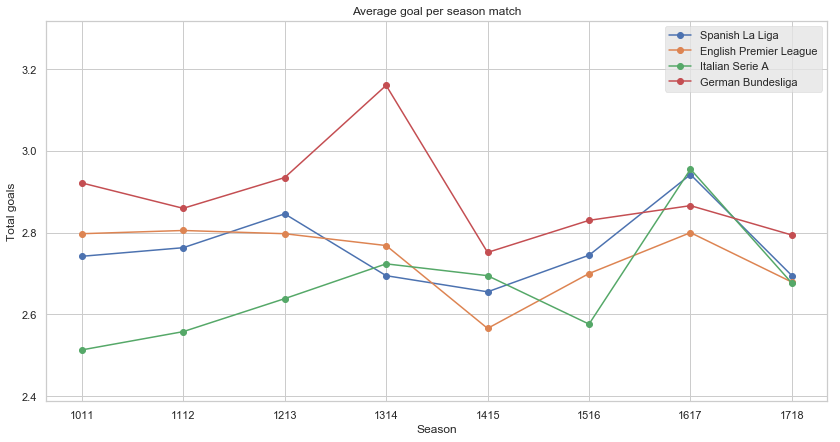

In [281]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)

plt.ylim(min(groupby['sum']) - min(groupby['sum']) * 0.05, max(groupby['sum']) + max(groupby['sum']) * 0.05)
ax.plot()
ax.set_title('Average goal per season match')

plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel('Season')
plt.ylabel('Total goals')
num_seasons = range(len(seasons))

plt.plot(num_seasons, groupby['sum'][groupby['League']=='LALIGA'], label = "Spanish La Liga", marker = 'o')
plt.plot(num_seasons, groupby['sum'][groupby['League']=='EPL'], label = "English Premier League", marker = 'o')
plt.plot(num_seasons, groupby['sum'][groupby['League']=='SERIE'], label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons, groupby['sum'][groupby['League']=='BUNDES'], label = "German Bundesliga", marker = 'o')

plt.legend(loc = 0)

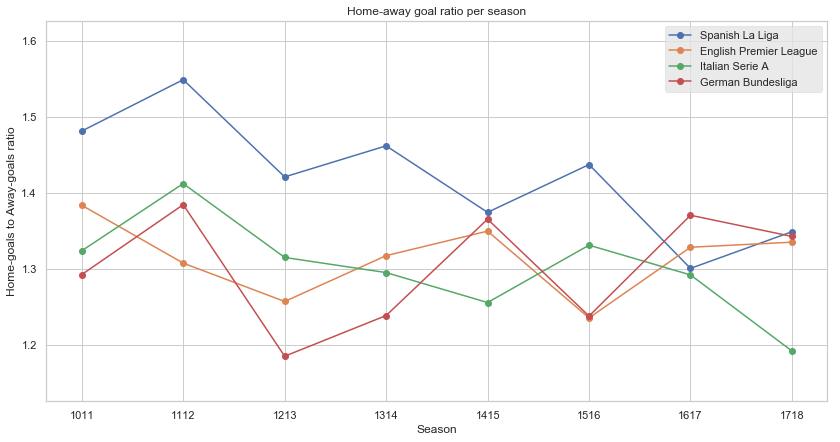

In [284]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)

plt.ylim(min(groupby['ratio']) - min(groupby['ratio']) * 0.05, max(groupby['ratio']) + max(groupby['ratio']) * 0.05)
ax.plot()
ax.set_title('Home-away goal ratio per season')

plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel('Season')
plt.ylabel('Home-goals to Away-goals ratio')
num_seasons = range(len(seasons))

plt.plot(num_seasons, groupby['ratio'][groupby['League']=='LALIGA'], label = "Spanish La Liga", marker = 'o')
plt.plot(num_seasons, groupby['ratio'][groupby['League']=='EPL'], label = "English Premier League", marker = 'o')
plt.plot(num_seasons, groupby['ratio'][groupby['League']=='SERIE'], label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons, groupby['ratio'][groupby['League']=='BUNDES'], label = "German Bundesliga", marker = 'o')

plt.legend(loc = 1)

In [286]:
def insertLeague(row):
    if row['Home_Name'] in LALIGA_teams:
        league = 'LALIGA'
    elif row['Home_Name'] in EPL_teams:
        league = 'EPL'
    elif row['Home_Name'] in SERIE_teams:
        league = 'SERIE'
    else:
        league = 'BUNDES'
    return league

In [287]:
h_groupby = data.groupby([data['Home_Name'], data['Season']]).sum()
h_groupby = h_groupby.reset_index()
a_groupby = data.groupby([data['Away_Name'], data['Season']]).sum()
a_groupby = a_groupby.reset_index()
GF = h_groupby['Home_GF'] + a_groupby['Away_GF']
GA = h_groupby['Away_GF'] + a_groupby['Home_GF']
goaldifference = GF - GA
groupby = data.groupby([data['Home_Name'], data['Season']]).sum()
groupby = groupby.reset_index()
groupby['GF'] = GF
groupby['GA'] = GA
groupby['GD'] = goaldifference
groupby['League'] = groupby.apply(lambda row: insertLeague(row), axis=1)

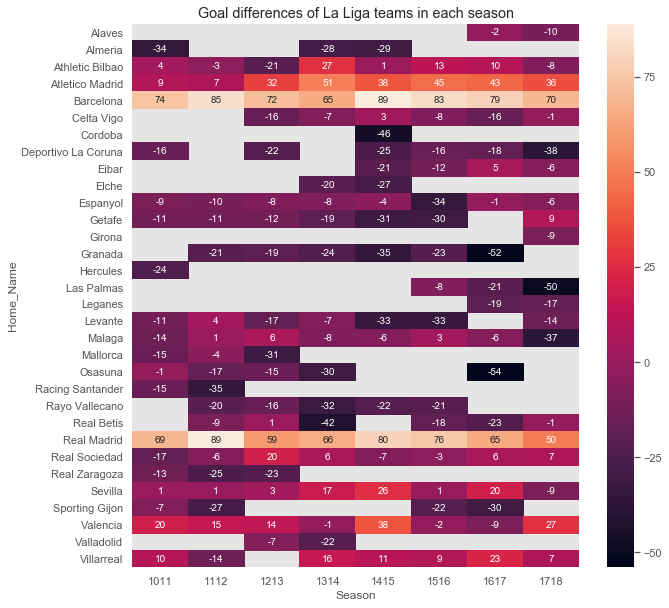

In [288]:
temp = groupby[groupby['Home_Name'].isin(LALIGA_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GD')
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Goal differences of La Liga teams in each season')
ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

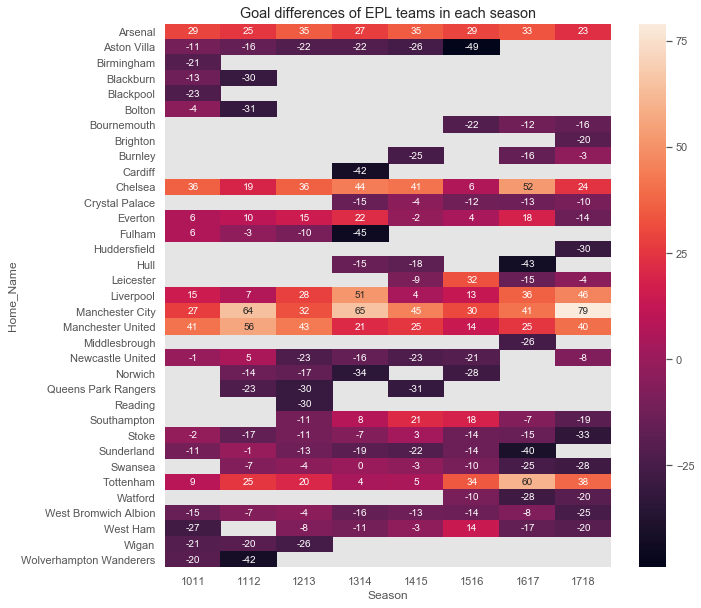

In [289]:
temp = groupby[groupby['Home_Name'].isin(EPL_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GD')
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Goal differences of EPL teams in each season')
ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

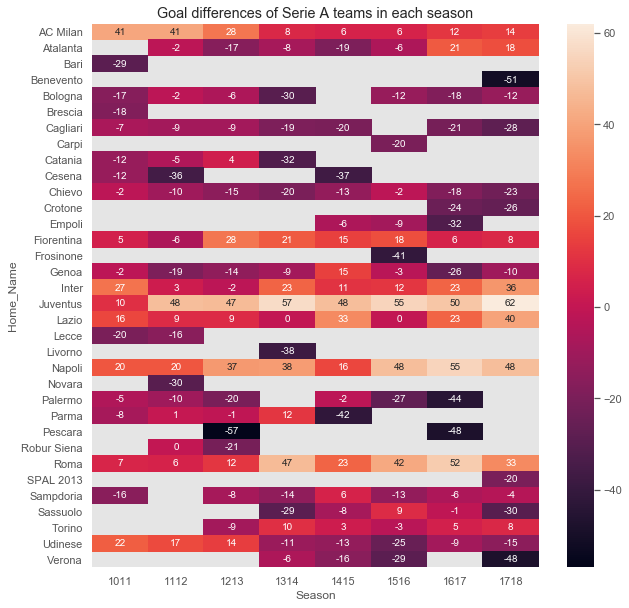

In [290]:
temp = groupby[groupby['Home_Name'].isin(SERIE_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GD')
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Goal differences of Serie A teams in each season')
ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

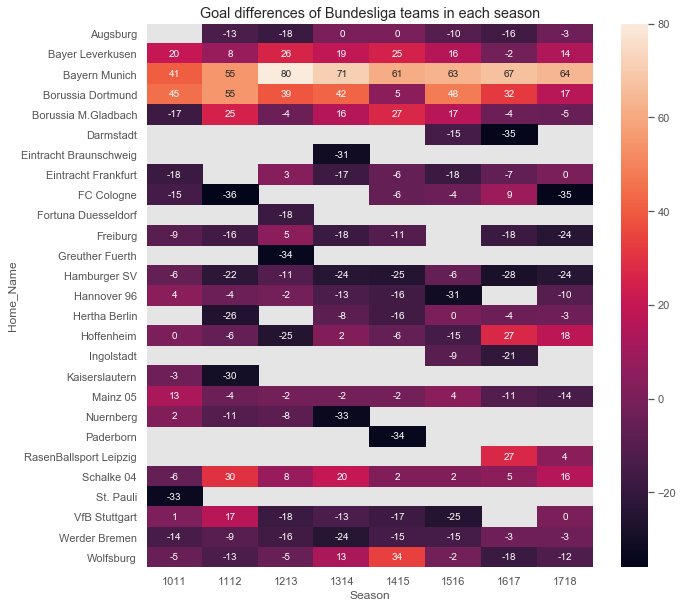

In [291]:
temp = groupby[groupby['Home_Name'].isin(BUNDES_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GD')
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Goal differences of Bundesliga teams in each season')
ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

In [35]:
temp = groupby[groupby['Home_Name'].isin(LALIGA_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GA')
#f, ax = plt.subplots(figsize=(10, 10))
#ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

In [36]:
temp = groupby[groupby['Home_Name'].isin(EPL_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GA')
#f, ax = plt.subplots(figsize=(10, 10))
#ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

In [37]:
temp = groupby[groupby['Home_Name'].isin(SERIE_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GA')
#f, ax = plt.subplots(figsize=(10, 10))
#ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

In [38]:
temp = groupby[groupby['Home_Name'].isin(BUNDES_teams) ==True]
heatmap = temp.pivot('Home_Name', 'Season', 'GA')
#f, ax = plt.subplots(figsize=(10, 10))
#ax = sns.heatmap(heatmap, annot=True, fmt='.10g')

In [39]:
#가장 운이 좋은 팀

In [292]:
def MPE(row):
    Goal = row['GF']
    Lose = row['GA']
    if row['League'] == 'BUNDES':
        Match_num = 34
    else:
        Match_num = 38
    mpe = (Goal**1.122777 / (Goal**1.072388 + Lose**1.127246)) * 2.49973 * Match_num
    return mpe

In [293]:
groupby['MPE score'] = groupby.apply(lambda row: MPE(row), axis=1)

In [294]:
def mpeTable(league, season):
    mpe_ = groupby[['League','Season','Home_Name','GF','GA','MPE score']][(groupby['League'] == league) & (groupby['Season'] == season)].sort_values('Home_Name', ascending=True).reset_index(drop=True)
    mpe_ = mpe_.rename(columns={'Home_Name': 'Team'})
    temp = leagueTable[(leagueTable['League']==league)&(leagueTable['Season']==season)].sort_values('Team', ascending=True).reset_index(drop=True)
    mpe_['Pts'] = temp['Pts']
    mpe_['Differ'] = mpe_.apply(lambda row: calculatediffer(row, 'Pts', 'MPE score'), axis=1)
    
    mpe_ = mpe_.sort_values('MPE score', ascending=False)
    predicRank = [i+1  for i in range(mpe_.shape[0])]
    mpe_['Prd Rank'] = predicRank
    mpe_ = mpe_.sort_values('Pts', ascending=False)
    realRank = [i+1  for i in range(mpe_.shape[0])]
    mpe_['Real Rank'] = realRank
    mpe_ = mpe_.reset_index(drop=True)
    return mpe_

In [295]:
mpeTable('EPL', 1516)

,League,Season,Team,GF,GA,MPE score,Pts,Differ,Prd Rank,Real Rank
0,EPL,1516,Leicester,68.0,36.0,72.732441,81,8.267559,2,1
1,EPL,1516,Arsenal,65.0,36.0,71.222095,71,-0.222095,3,2
2,EPL,1516,Tottenham,69.0,35.0,74.093011,70,-4.093011,1,3
3,EPL,1516,Manchester City,71.0,41.0,70.074204,66,-4.074204,4,4
4,EPL,1516,Manchester United,49.0,35.0,62.563970,66,3.436030,6,5
5,EPL,1516,Southampton,59.0,41.0,63.754222,63,-0.754222,5,6
6,EPL,1516,West Ham,65.0,51.0,59.915321,62,2.084679,7,7
7,EPL,1516,Liverpool,63.0,50.0,59.493668,60,0.506332,8,8
8,EPL,1516,Stoke,41.0,55.0,42.307893,51,8.692107,15,9
9,EPL,1516,Chelsea,59.0,53.0,55.332906,50,-5.332906,9,10


In [296]:
mpeTable('EPL', 1718)

,League,Season,Team,GF,GA,MPE score,Pts,Differ,Prd Rank,Real Rank
0,EPL,1718,Manchester City,106.0,27.0,94.131026,100,5.868974,1,1
1,EPL,1718,Manchester United,68.0,28.0,80.277321,81,0.722679,2,2
2,EPL,1718,Tottenham,74.0,36.0,75.537672,77,1.462328,4,3
3,EPL,1718,Liverpool,84.0,38.0,78.050436,75,-3.050436,3,4
4,EPL,1718,Chelsea,62.0,38.0,67.905761,70,2.094239,5,5
5,EPL,1718,Arsenal,74.0,51.0,64.395448,63,-1.395448,6,6
6,EPL,1718,Burnley,36.0,39.0,48.790605,54,5.209395,8,7
7,EPL,1718,Everton,44.0,58.0,42.884276,49,6.115724,11,8
8,EPL,1718,Leicester,56.0,60.0,49.553561,47,-2.553561,7,9
9,EPL,1718,Newcastle United,39.0,47.0,45.539222,44,-1.539222,9,10


In [297]:
totalMpe = pd.DataFrame(columns=['League', 'Season', 'Team', 'GF', 'GA', 'MPE score', 'Pts', 'Differ','Prd Rank', 'Real Rank'])
for league in leagues:
    for season in seasons:
        temp = mpeTable(league, season)
        totalMpe = pd.concat([totalMpe, temp], axis=0)
totalMpe = totalMpe.reset_index(drop=True)
totalMpe['Pts'] = totalMpe['Pts'].astype(float)

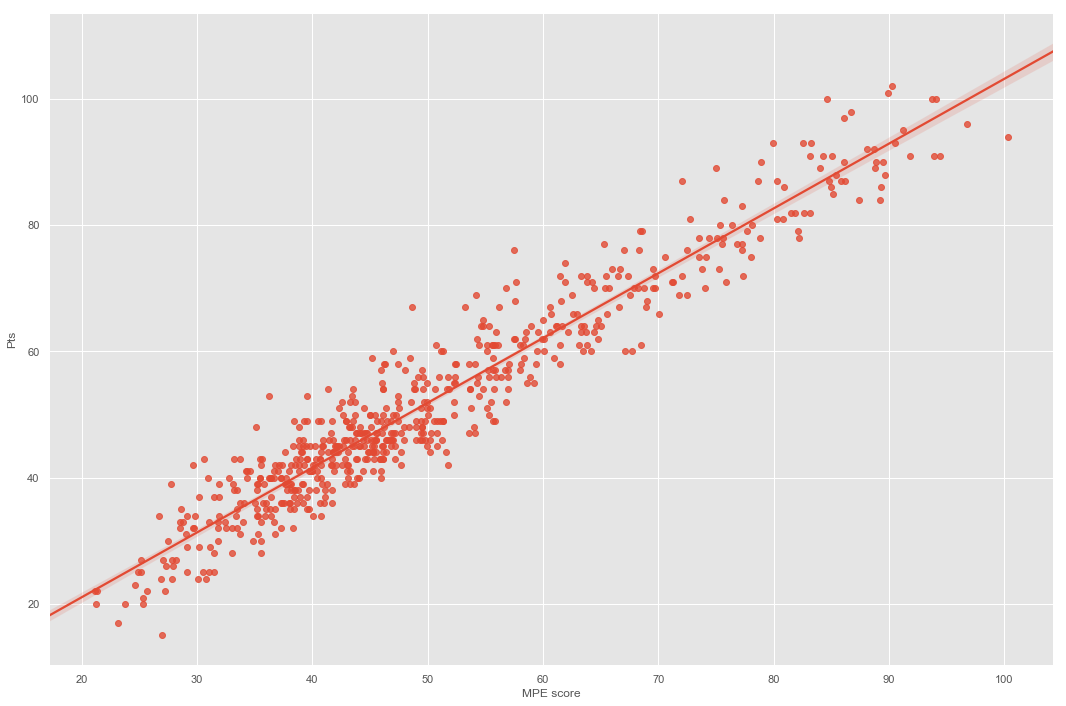

In [298]:
plt.figure(figsize=(18,12))
sns.regplot(x="MPE score", y="Pts", data=totalMpe)
plt.show()

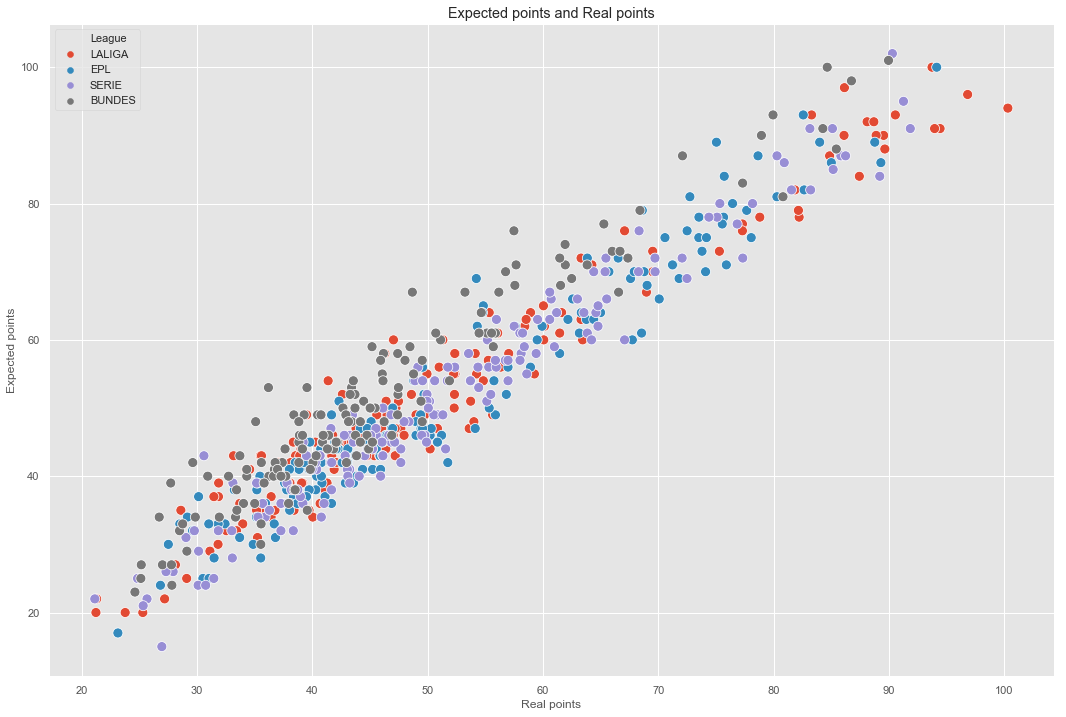

In [303]:
plt.figure(figsize=(18,12))
ax = sns.scatterplot(x="MPE score", y="Pts", hue='League', s=100, data=totalMpe)
ax.set_title('Expected points and Real points')
plt.xlabel('Real points')
plt.ylabel('Expected points')
plt.show()

In [305]:
from sklearn.metrics import r2_score
r2_score(totalMpe['MPE score'], totalMpe['Pts'])

0.8970900562482983

In [307]:
totalMpe[['MPE score','Pts']].corr()

,MPE score,Pts
MPE score,1.000000,0.960409
Pts,0.960409,1.000000


In [49]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row['odds_w'],row['odds_d'],row['odds_l']]
    #change odds to probability
    probs = [o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)
data['entropy'] = data.apply(match_entropy,axis=1)

In [51]:
mean_ent = data.groupby(('Season','League')).entropy.mean()
mean_ent = mean_ent.reset_index().pivot(index='Season', columns='League', values='entropy')

C:\Users\dlfdus\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  if __name__ == '__main__':


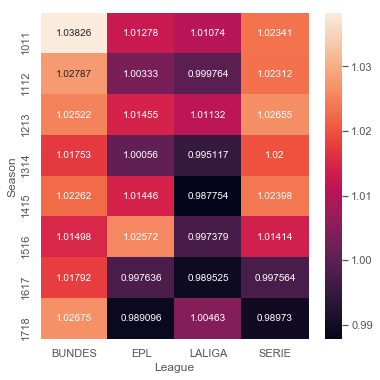

In [52]:
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(mean_ent, annot=True, fmt='.6g')

In [333]:
h_groupby = data.groupby([data['Home_Name'], data['Season']]).mean()
h_groupby = h_groupby.reset_index()
a_groupby = data.groupby([data['Away_Name'], data['Season']]).mean()
a_groupby = a_groupby.reset_index()
TSNEgroupby = data.groupby([data['Home_Name'], data['Season']]).mean()
TSNEgroupby = TSNEgroupby.reset_index()
TSNEgroupby = TSNEgroupby[['Home_Name','Season']]

In [334]:
for idx, i in enumerate(range(50, 106, 2)):
    TSNEgroupby[idx] = h_groupby.iloc[:,i] + a_groupby.iloc[:,i+1]

In [335]:
TSNEgroupby.head()

,Home_Name,Season,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,AC Milan,1011,0.228755,11.578947,98.789474,167.631579,1155.368421,756.894737,1.313761,599.105263,...,0.103749,0.072035,31.052632,22.105263,1.947368,22.105263,43.631579,14.202632,1433.157895,1.655540
1,AC Milan,1112,0.261556,11.684211,98.947368,166.789474,1197.578947,785.210526,1.316664,40.842105,...,0.115673,0.071636,31.526316,22.368421,1.578947,25.263158,42.894737,14.132632,1465.526316,1.517726
2,AC Milan,1213,0.223590,12.315789,94.315789,170.631579,1075.578947,698.052632,1.303547,535.000000,...,0.124420,0.063618,33.473684,22.315789,1.947368,21.421053,46.210526,14.065789,1359.894737,1.400603
3,AC Milan,1314,0.216539,10.578947,98.526316,167.210526,1067.631579,706.000000,1.325974,535.526316,...,0.103820,0.062646,32.473684,23.315789,1.000000,20.947368,37.631579,13.761579,1305.315789,1.316066
4,AC Milan,1415,0.276171,7.842105,100.842105,161.421053,982.789474,650.105263,1.326669,517.210526,...,0.093741,0.070761,23.684211,16.789474,0.894737,26.947368,34.368421,13.592105,1216.578947,1.335952


In [336]:
TrainTSNE = False

In [337]:
if TrainTSNE == True:
    from sklearn.manifold import TSNE

    model = TSNE(n_components=2, learning_rate=100, perplexity=20, method='barnes_hut')
    transformed = model.fit_transform(TSNEgroupby.iloc[:, 2:])
    transformed = pd.DataFrame(data=transformed, columns=['1','2'])


    transformed['Season'] = TSNEgroupby['Season']
    transformed['Team'] = TSNEgroupby['Home_Name']

    with open('data/pickle/TSNE(Team).pkl', 'wb') as f:
        pickle.dump(transformed, f)
else:
    with open('data/pickle/TSNE(Team).pkl', 'rb') as f:
        transformed = pickle.load(f)

In [338]:
def Euclidean(targetdata, data):
    for idx, i in enumerate(data):
        temp = 0
        for j in range(len(i)):
            temp += (targetdata[j] - i[j]) ** 2
        temp = temp ** (1/2)
        yield (temp, idx)

In [339]:
def get_similar_Team(data_, season, team, topn = 10):
    sns.set(style="ticks")
    sns.set_style('whitegrid')
    sns.set_color_codes()
    
    seasonteam = str(season)+' '+team
    
    xy = data_[['1', '2']].values
    target_match = data_[['1', '2']][(data_['Season'] == season) & (data_['Team'] == team)].values
    similar_list = list(Euclidean(target_match[0], xy))
    similar_list.sort(reverse=False)
    target_index = similar_list[0][1]
    similar_list = similar_list[1 :topn +1]
    distance, results = [], []
    print('Top {} most similar teams to {}\n'.format(topn, seasonteam))
    for i in similar_list:
        index = i[1]
        distance.append(i[0])
        print('{} {} - distance : {}'.format(data_.loc[index, 'Season'], data_.loc[index, 'Team'], i[0]))
    plt.figure(figsize=(18,12))
    ax = sns.scatterplot(x='1', y='2', sizes=(20, 300), data = data_)
    similarindex = [i for i in similar_list[1:topn+1]]
    
    for idx, i in enumerate(similarindex):
        plt.annotate('', (data_.loc[i[1] ,'1'], data_.loc[i[1], '2']),
                    xytext=(data_.loc[i[1] ,'1'] +5, data_.loc[i[1], '2'] +5),
                         arrowprops=dict(facecolor='black', shrink=0.15),)
        plt.rcParams.update({'font.size': 30})

    plt.annotate(seasonteam, (data_.loc[target_index ,'1'], data_.loc[target_index, '2']),
                     xytext=(data_.loc[target_index ,'1'] +5, data_.loc[target_index, '2'] +5),
                     arrowprops=dict(facecolor='red', shrink=0.05),)
    plt.show()

Top 10 most similar teams to 1314 Stoke

1516 Bologna - distance : 0.7612709635384728
1516 Aston Villa - distance : 1.0135183831633718
1516 Genoa - distance : 1.5902938889580882
1415 VfB Stuttgart - distance : 1.7295098851033848
1112 Wigan - distance : 1.7579987769046095
1516 Villarreal - distance : 1.9298530247972179
1516 Eintracht Frankfurt - distance : 2.266311789035424
1415 Stoke - distance : 2.3115888448992274
1415 Eintracht Frankfurt - distance : 2.337826126359453
1516 Hamburger SV - distance : 2.445674104828792


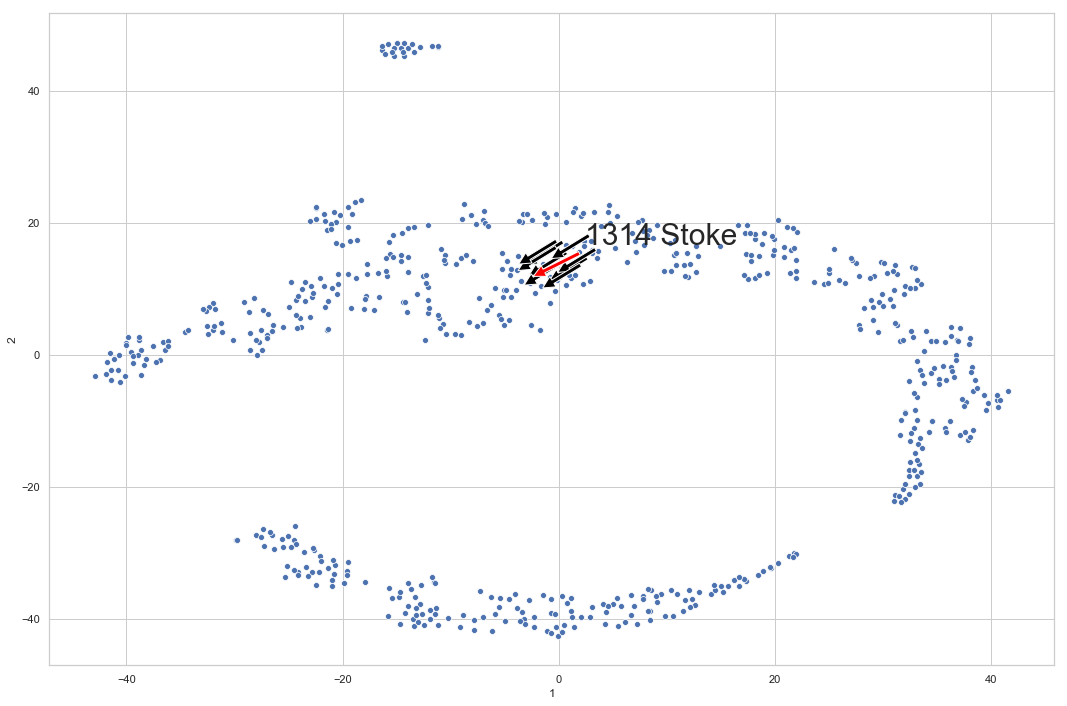

In [340]:
get_similar_Team(transformed, 1314, 'Stoke')

Top 10 most similar teams to 1718 Manchester City

1718 Napoli - distance : 0.7072606290576554
1516 Bayern Munich - distance : 0.8464998662261941
1415 Bayern Munich - distance : 0.868923725464573
1617 Bayern Munich - distance : 1.1172078382733435
1617 Napoli - distance : 1.712975500205498
1415 Barcelona - distance : 1.9355656630110276
1718 Bayern Munich - distance : 2.721813321482653
1516 Napoli - distance : 2.89751423320634
1516 Borussia Dortmund - distance : 3.4846966974218483
1718 Barcelona - distance : 4.022817421926655


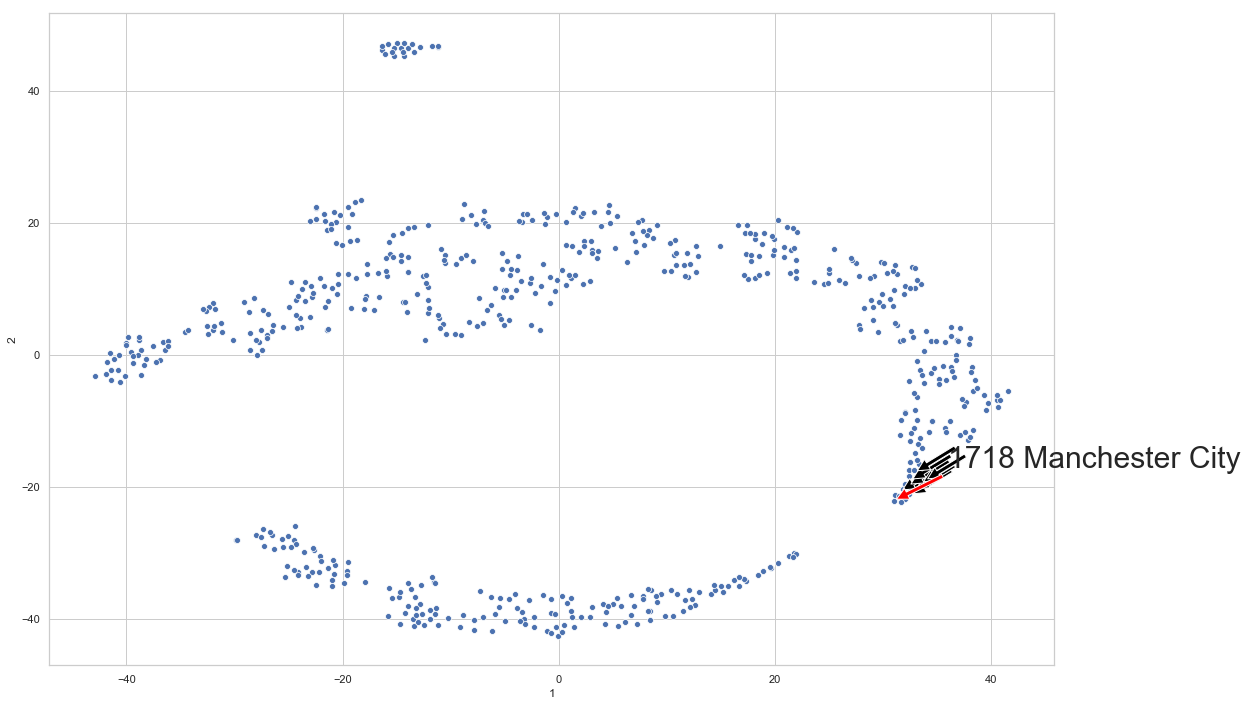

In [341]:
get_similar_Team(transformed, 1718, 'Manchester City', topn=10)

Top 10 most similar teams to 1617 Manchester City

1718 Real Madrid - distance : 0.6003326318970559
1617 Liverpool - distance : 0.8922394581942471
1617 Barcelona - distance : 0.9605894782618805
1718 Liverpool - distance : 1.2017277971608706
1718 Arsenal - distance : 1.3053133275467033
1718 Tottenham - distance : 1.6757519877411828
1516 Barcelona - distance : 1.8326379042454939
1718 Barcelona - distance : 1.9945160860405449
1415 Manchester City - distance : 2.508181394427274
1314 Arsenal - distance : 2.958402535302447


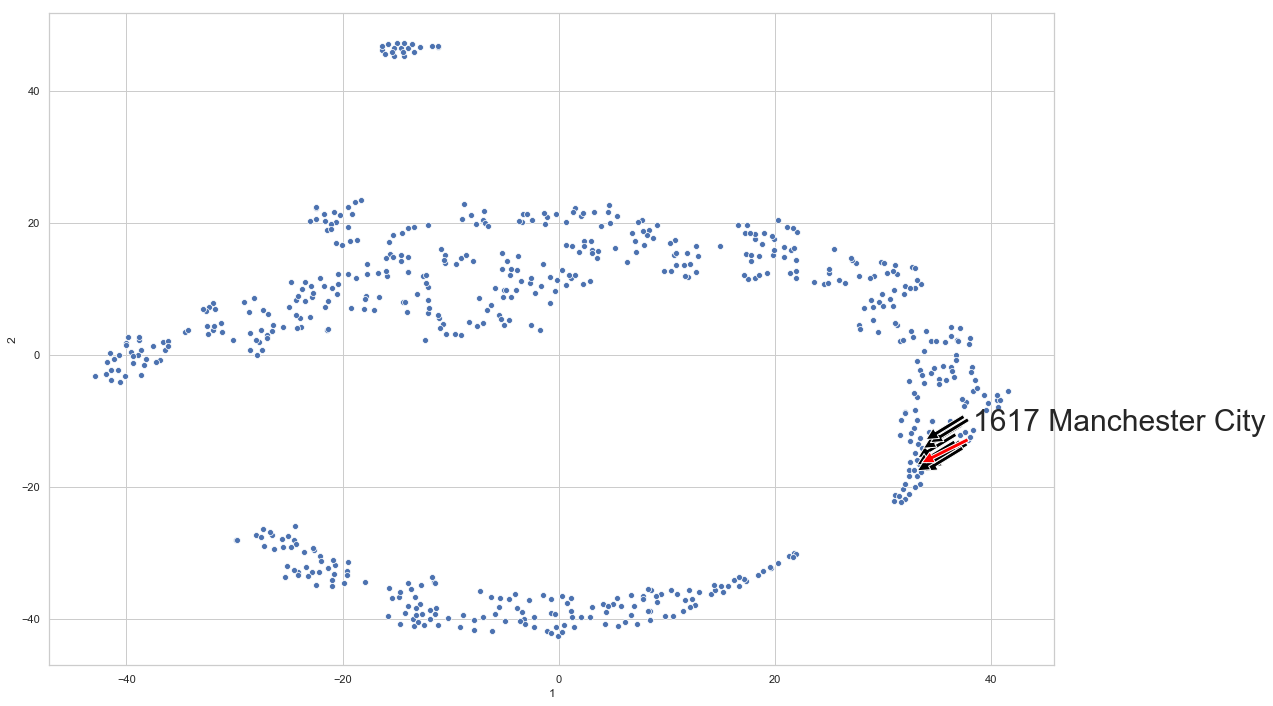

In [346]:
get_similar_Team(transformed, 1617, 'Manchester City')

Top 10 most similar teams to 1516 Carpi

1415 Crystal Palace - distance : 0.5298772910207785
1314 Crystal Palace - distance : 0.7491829265335226
1415 Almeria - distance : 0.7549050394651174
1112 Blackburn - distance : 0.9966011765401684
1516 West Bromwich Albion - distance : 1.2922947656416361
1213 Reading - distance : 1.6611914960059209
1617 West Bromwich Albion - distance : 1.7929863111183855
1617 Sunderland - distance : 1.8860277507867214
1314 West Ham - distance : 1.9211375645327466
1516 Sunderland - distance : 1.984096177330736


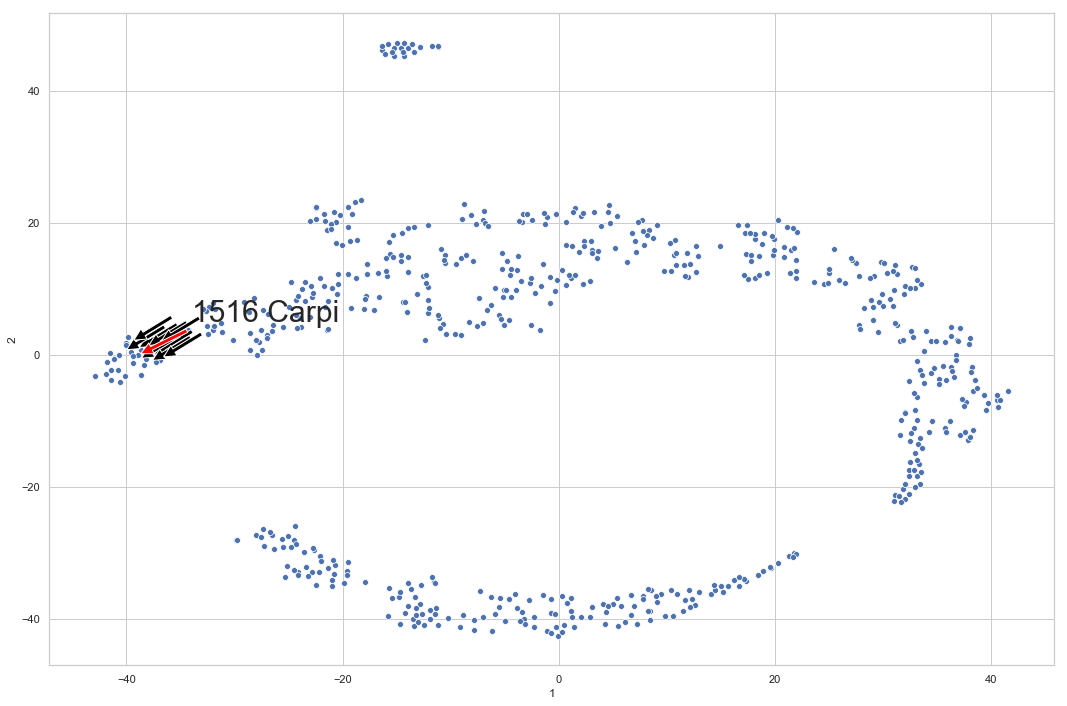

In [343]:
get_similar_Team(transformed, 1516, 'Carpi')

Top 10 most similar teams to 1314 Arsenal

1415 Manchester City - distance : 0.6212544457354208
1617 Arsenal - distance : 0.9215580748368174
1213 Arsenal - distance : 0.9896221268672781
1718 Tottenham - distance : 1.340098502980133
1516 Arsenal - distance : 1.8057913895435298
1112 Manchester City - distance : 2.142205895883763
1718 Chelsea - distance : 2.2376299030084508
1718 Real Madrid - distance : 2.397841924836446
1011 Arsenal - distance : 2.5019515544612116
1617 Liverpool - distance : 2.8238601269042056


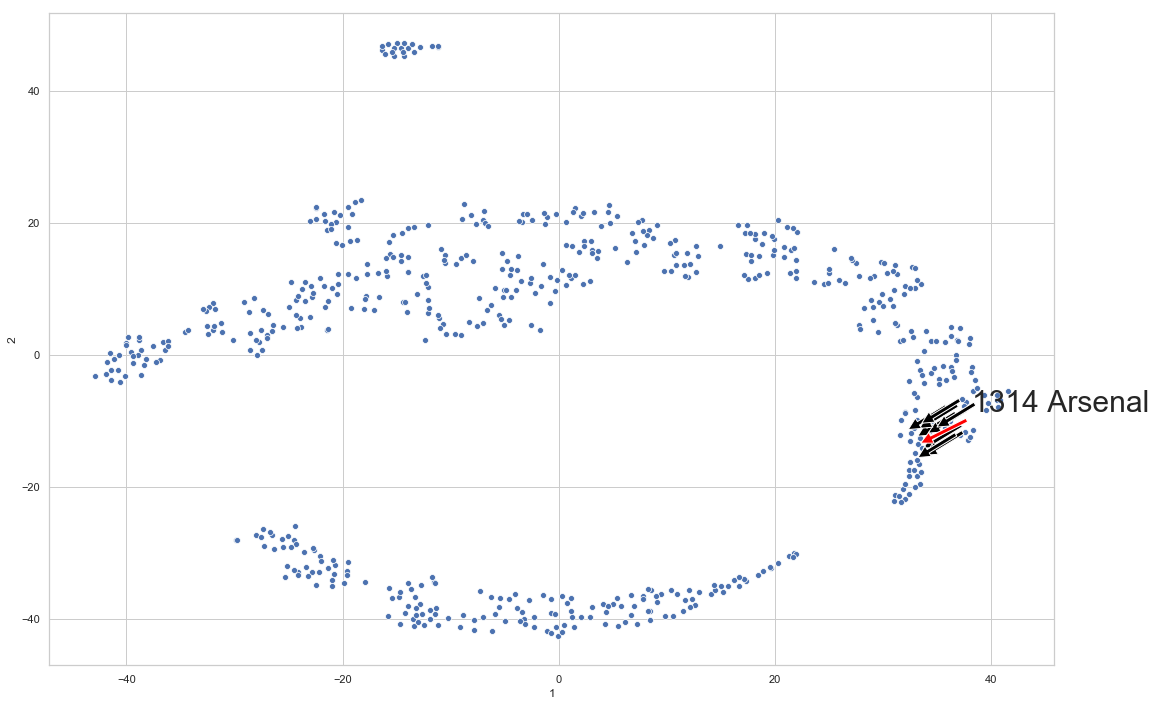

In [345]:
get_similar_Team(transformed, 1314, 'Arsenal')